# Store Sales Forecasting

## Evaluation Metric

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

In the first pass, I ignored history and used the generic XGBRegressor to make predictions. I tried using the objective of squared mean error, but the model consistently returned terrible results with that. Using a different metric to fit the XGBRegressor, I was still able to get the Root Mean Squared Logarithmic Error to be 1.54655, but on the Kaggle data it was scored 2.018. In this pass, I'll try to use the Holiday table to try and get an improvement on my results.

In [1]:
# Basic imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

## Data

This dataset has several csv files. It looks like most of them can be joined to the training data via one column or another

1. Holidays_events -> Can join on Date. There is some tricky moved variable I might need to write a function for.
2. Oil -> Oil price for the day. Can join on the date (Prices for both train and test are included).
3. Stores -> Store info. Can join on store number
4. Transactions -> Can join on Date+StoreNbr

In [2]:
df_train = pd.read_csv('./Data/train.csv')
df_test = pd.read_csv('./Data/test.csv')
df_oil = pd.read_csv('./Data/oil.csv')
df_stores = pd.read_csv('./Data/stores.csv')
df_transactions = pd.read_csv('./Data/transactions.csv')
df_holidays = pd.read_csv('./Data/holidays_events.csv')

# Store originals just in case
df_train0 = df_train.copy()
df_test0 = df_test.copy()
df_oil0 = df_oil.copy()
df_stores0 = df_stores.copy()
df_transactions0 = df_transactions.copy()
df_holidays0 = df_holidays.copy()

## Data exploration

In [3]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [6]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
# Check for nulls, NaNs, duplicates
df_train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [8]:
# Oil is the only dataframe that has nulls. We'll want to impute the values. (Would probably make sense to average out the day before and after for price)
df_oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [9]:
# Check for duplicates
print('Duplicates Training: ', df_train.duplicated().sum())
print('Duplicates Oil: ', df_oil.duplicated().sum())
print('Duplicates Transactions: ', df_transactions.duplicated().sum())
print('Duplicates Stores: ', df_stores.duplicated().sum())
print('Duplicates Holidays: ', df_holidays.duplicated().sum())

Duplicates Training:  0
Duplicates Oil:  0
Duplicates Transactions:  0
Duplicates Stores:  0
Duplicates Holidays:  0


## Data Preprocessing

### Imputing values in oil

In [10]:
# Impute the values for the oil dataframe

# Function to calculate median of adjacent rows
def median_of_adjacent(row_index, df):
    if row_index == 0:
        # If it's the first row, take the median with the next row
        return np.median([df.loc[row_index, 'dcoilwtico'], df.loc[row_index + 1, 'dcoilwtico']])
    elif row_index == len(df) - 1:
        # If it's the last row, take the median with the previous row
        return np.median([df.loc[row_index, 'dcoilwtico'], df.loc[row_index - 1, 'dcoilwtico']])
    else:
        # Otherwise, take the median of the previous and next rows
        return np.median([df.loc[row_index - 1, 'dcoilwtico'], df.loc[row_index + 1, 'dcoilwtico']])

# Find indices of missing values
missing_indices = df_oil[df_oil['dcoilwtico'].isna()].index

# Fill missing values
for idx in missing_indices:
    df_oil.at[idx, 'dcoilwtico'] = median_of_adjacent(idx, df_oil)

### Dealing with Holidays

There are a few cases of holidays. 

1. There are National, Local and Regional holidays. I should apply National holidays to all stores, and local/regional ones only when locale matches.
2. Transfers. Holidays that are transferred should not be considered Holidays, but rather the day that it was transferred to should be the holiday.

I want the additional column in my df_train: 'is_holiday', 'holiday_type', 'holiday_description','holiday_transferred'

In [11]:
# make sure data is a datetime object
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

I think it will be easier if I split apart the holidays by type

In [12]:
df_holidays['locale'].value_counts()

locale
National    174
Local       152
Regional     24
Name: count, dtype: int64

In [13]:
df_holidays['description'].head(30)

0                      Fundacion de Manta
1           Provincializacion de Cotopaxi
2                     Fundacion de Cuenca
3               Cantonizacion de Libertad
4               Cantonizacion de Riobamba
5                  Cantonizacion del Puyo
6               Cantonizacion de Guaranda
7           Provincializacion de Imbabura
8              Cantonizacion de Latacunga
9                    Fundacion de Machala
10             Fundacion de Santo Domingo
11             Cantonizacion de El Carmen
12               Cantonizacion de Cayambe
13                Fundacion de Esmeraldas
14          Primer Grito de Independencia
15                  Fundacion de Riobamba
16                    Fundacion de Ambato
17                    Fundacion de Ibarra
18               Cantonizacion de Quevedo
19             Independencia de Guayaquil
20    Traslado Independencia de Guayaquil
21                        Dia de Difuntos
22                Independencia de Cuenca
23     Provincializacion de Santo 

I want to change the descriptions to remove "Translado", so that the holidays can get grouped together in the regression. The holiday type Translated is already there.

In [14]:
df_holidays['description'] = df_holidays['description'].str.replace('Traslado ', '', regex=False)

In [15]:
df_holidays_national = df_holidays.loc[df_holidays['locale'] == 'National']
df_holidays_local = df_holidays.loc[df_holidays['locale'] == 'Local']
df_holidays_regional = df_holidays.loc[df_holidays['locale'] == 'Regional']

# prep the column names to be merged into datasets uniquely
df_holidays_national = df_holidays_national.rename(columns={
        'type': 'holiday_type_n',
        'description': 'holiday_description_n',
        'transferred': 'holiday_transferred_n'
    })

df_holidays_local = df_holidays_local.rename(columns={
        'type': 'holiday_type_l',
        'description': 'holiday_description_l',
        'transferred': 'holiday_transferred_l'
    })

df_holidays_regional = df_holidays_regional.rename(columns={
        'type': 'holiday_type_r',
        'description': 'holiday_description_r',
        'transferred': 'holiday_transferred_r'
    })

In [16]:
df_stores['state'].unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [17]:
df_holidays_regional['locale_name'].unique()

array(['Cotopaxi', 'Imbabura', 'Santo Domingo de los Tsachilas',
       'Santa Elena'], dtype=object)

The regional holidays are statewide holidays. Need should match up date, state

The local holidays are city-wide holidays. Need to match up date, city

## Joining the dataframes

In [18]:
# Use the different holidays dataframes to apply holiday data. Need the have the store info merged in before calling this
def fill_holidays(df0):
    df = df0.copy()
    df['date'] = pd.to_datetime(df['date'])

    # Merge the national dataframe on 'date' alone
    df = df.merge(df_holidays_national[['date', 'holiday_type_n', 'holiday_description_n', 'holiday_transferred_n']], 
                  on='date', how='left')
    
    # Merge the regional dataframe on 'date' and 'state'
    df = df.merge(df_holidays_regional[['date', 'locale_name', 'holiday_type_r', 'holiday_description_r', 'holiday_transferred_r']], 
                left_on=['date', 'state'], 
                right_on=['date', 'locale_name'], 
                how='left')

    df.drop('locale_name', axis=1, inplace=True)
        
    # Merge the local dataframe on 'date' and 'city'
    df = df.merge(df_holidays_local[['date', 'locale_name', 'holiday_type_l', 'holiday_description_l', 'holiday_transferred_l']], 
                  left_on=['date','city'], right_on=['date','locale_name'], how='left')
    
    df.drop('locale_name', axis=1, inplace=True)

    # Fill NaN values for non-matching rows
    df['holiday_type_n'] = df['holiday_type_n'].fillna('None')
    df['holiday_description_n'] = df['holiday_description_n'].fillna('NA')
    df['holiday_transferred_n'] = df['holiday_transferred_n'].fillna('NA')
    
    df['holiday_type_r'] = df['holiday_type_r'].fillna('None')
    df['holiday_description_r'] = df['holiday_description_r'].fillna('NA')
    df['holiday_transferred_r'] = df['holiday_transferred_r'].fillna('NA')

    df['holiday_type_l'] = df['holiday_type_l'].fillna('None')
    df['holiday_description_l'] = df['holiday_description_l'].fillna('NA')
    df['holiday_transferred_l'] = df['holiday_transferred_l'].fillna('NA')

    return df

# Join all the dataframes together
def join_all_to_df(df0):
    df = df0.copy()
    # Join oil
    df = pd.merge(df, df_oil, on='date', how='left')
    # Join stores
    df = pd.merge(df, df_stores, on='store_nbr', how='left')
    # Join transactions
    df = pd.merge(df, df_transactions, left_on=['date','store_nbr'], right_on=['date','store_nbr'], how='left')
    # Join holidays
    df = fill_holidays(df)

    return df

In [19]:
df_train = join_all_to_df(df_train)

In [20]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,...,transactions,holiday_type_n,holiday_description_n,holiday_transferred_n,holiday_type_r,holiday_description_r,holiday_transferred_r,holiday_type_l,holiday_description_l,holiday_transferred_l
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,...,NaN,Holiday,Primer dia del ano,False,None,NA,NA,None,NA,NA
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,...,NaN,Holiday,Primer dia del ano,False,None,NA,NA,None,NA,NA
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,...,NaN,Holiday,Primer dia del ano,False,None,NA,NA,None,NA,NA
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,...,NaN,Holiday,Primer dia del ano,False,None,NA,NA,None,NA,NA
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,...,NaN,Holiday,Primer dia del ano,False,None,NA,NA,None,NA,NA


## Observations

Looks like there is 1218 unique dates in oil, and 1600 in train. This leads to about 28% of the merged data being na. Something to keep an eye on.

Transactions has some missing too, about 8%. I also see some rows with no transactions and the sales are 0. Maybe these are holidays?

In [21]:
# Looks like there is 1218 unique dates in oil, and 1600 in train. This leads to about 28% of the merged data being na. Something to keep an eye on.
# Trnasactions has some missing too, about 8%
df_train.date.describe()
df_oil.date.describe()
df_transactions.date.describe()

count          83488
unique          1682
top       2017-08-15
freq              54
Name: date, dtype: object

In [22]:
# Looks like there is 1218 unique dates in oil, and 1600 in train. This leads to about 28% of the merged data being na. Something to keep an eye on.
# Trnasactions has some missing too, about 8%
df_train.isna().sum()

print('Oil price missing', 862488*100 / df_train.shape[0])
print('Transactions missing', 245784*100 / df_train.shape[0])

Oil price missing 28.670469504168494
Transactions missing 8.170250109697236


<Axes: xlabel='date'>

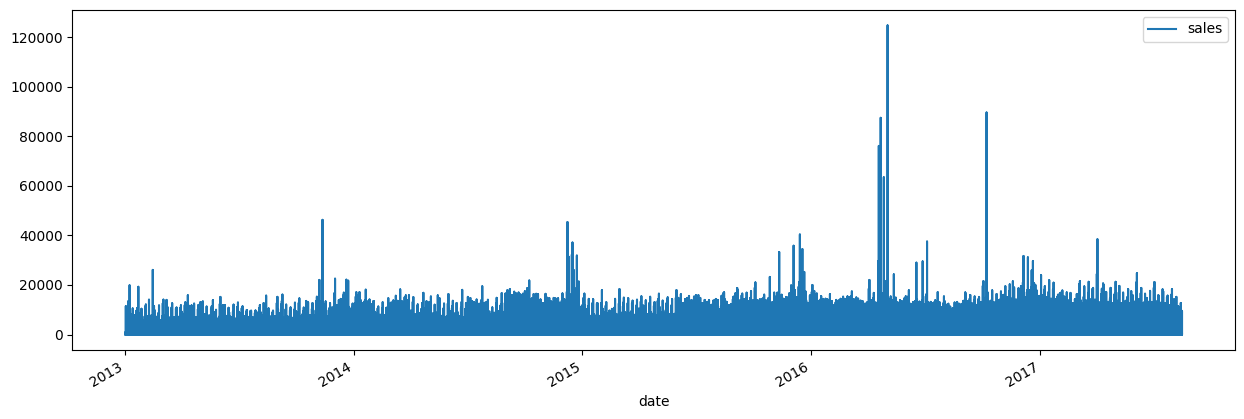

In [23]:
df_train.plot(x='date', y='sales', figsize=(15,5))

# Data preprocessing

In [24]:
def create_features(df0):
    df = df0.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    df['quarter'] = df.date.dt.quarter
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    df['day'] = df.date.dt.day
    df.drop('date', axis=1, inplace=True)
    return df

In [25]:
df_train = create_features(df_train)

# get dummies and drop id
df_train.drop('id', axis=1, inplace=True)
df_train = pd.get_dummies(df_train)

# Create a model

In [26]:
# Split the data. Lets pick a date to split on, and we want year as a feature so we'll split at 2016
train_set = df_train.loc[df_train['year'] < 2016]
test_set = df_train.loc[df_train['year'] >= 2016]

In [32]:
import xgboost as xgb

# Set up a regressor
xgb_reg = xgb.XGBRegressor(n_estimators=300, learning_rate = 0.05, early_stopping_rounds=50, random_state=42)

# This regressor for using the squared log error produced results where all the predictions were between 1 and 2. Poor results. 
# xgb_reg = xgb.XGBRegressor(objective='reg:squaredlogerror'n_estimators=500, learning_rate = 0.01, early_stopping_rounds=25, random_state=42)

y_train = train_set['sales']
y_test = test_set['sales']
X_train = train_set.drop('sales', axis=1)
X_test = test_set.drop('sales', axis=1)


In [33]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=50)

#import pickle
#path = './'

#with open(path+'xgb_reg_model.pickle', 'rb') as to_read:
#    xgb_reg = pickle.load(to_read)

[0]	validation_0-rmse:1286.99382
[50]	validation_0-rmse:612.62224
[100]	validation_0-rmse:555.27115
[150]	validation_0-rmse:545.71916
[200]	validation_0-rmse:537.78176
[250]	validation_0-rmse:536.10555
[299]	validation_0-rmse:539.14615


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [34]:
# save the model
import pickle

path = './'

with open(path+'xgb_reg_model.pickle', 'wb') as to_write:
    pickle.dump(xgb_reg, to_write)

# Evaluate the model

In [35]:
y_preds = xgb_reg.predict(X_test)

train_set_final = X_train
train_set_final['sales'] = y_train

test_set_final = X_test
test_set_final['sales_pred'] = y_preds
test_set_final['sales_actual'] = y_test

### Evaluation Metric

It looks like we have negative predictions, which won't work with mean squared log error. In this case, it doesn't make sense to have negative sales anyways. There might be something wrong with our model.

In [36]:
print(test_set_final.loc[test_set_final['sales_pred'] < 0].shape)
print(test_set_final.shape)

(120264, 209)
(1060554, 209)


Only a small percentage of our values are negative. In this case, I'm going to set them all to 0. With those at 0 we can evaluate our model.

In [37]:
test_set_final['sales_pred'] = test_set_final['sales_pred'].clip(lower=0)

print(test_set_final.loc[test_set_final['sales_pred'] < 0].shape)

(0, 209)


In [38]:
from sklearn.metrics import mean_squared_log_error

rmsle = np.sqrt(mean_squared_log_error(test_set_final['sales_actual'], test_set_final[['sales_pred']]))

print('Root mean squared log error:', rmsle)

Root mean squared log error: 1.5034830875750014


In [39]:
## Add back the date column

def add_date(df0):
    df = df0.copy()
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    return df

train_set_final = add_date(train_set_final)
test_set_final = add_date(test_set_final)

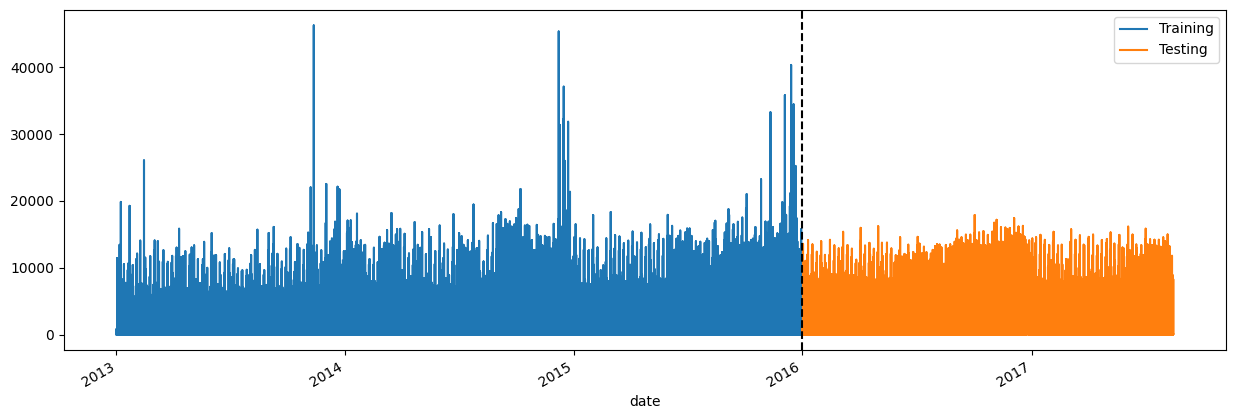

In [40]:
fig, ax = plt.subplots(figsize=(15,5))
train_set_final.plot(ax=ax, x='date', y='sales',label='Training Set')
test_set_final.plot(ax=ax, x='date', y='sales_pred',label='Testing Set Prediction')
ax.axvline('2016-01-01', color='black', linestyle='--')
ax.legend(['Training','Testing'])
plt.show()

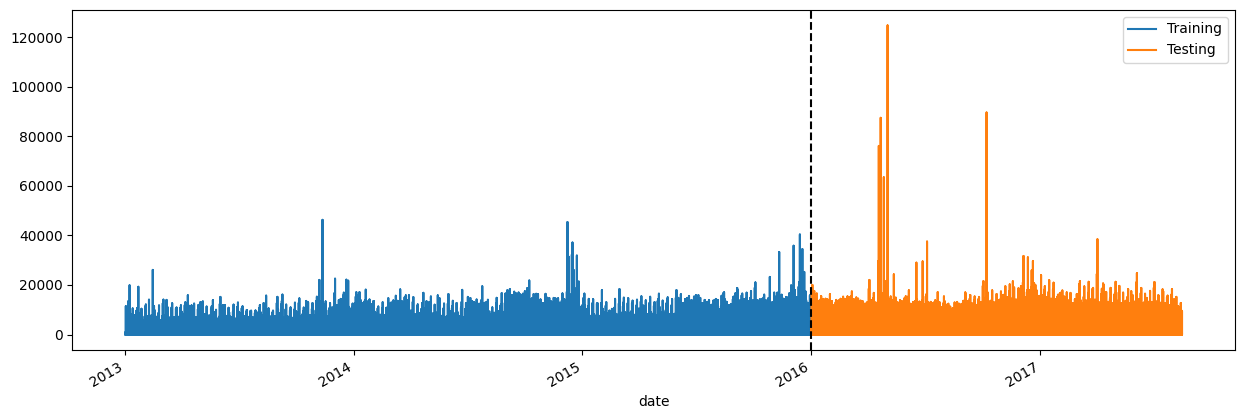

In [41]:
fig, ax = plt.subplots(figsize=(15,5))
train_set_final.plot(ax=ax, x='date', y='sales',label='Training Set')
test_set_final.plot(ax=ax, x='date', y='sales_actual',label='Testing Set Actual')
ax.axvline('2016-01-01', color='black', linestyle='--')
ax.legend(['Training','Testing'])
plt.show()

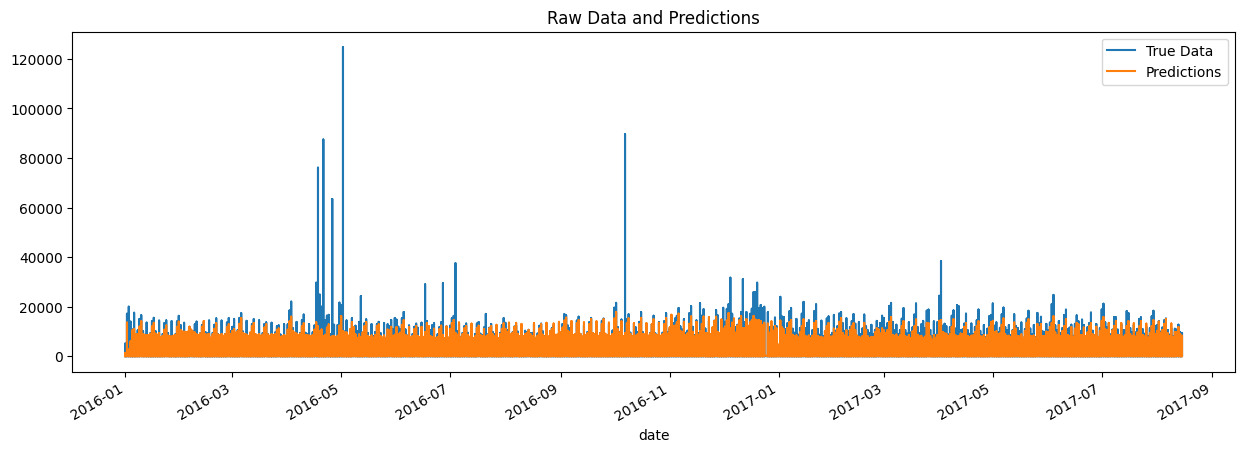

In [42]:
ax = test_set_final.plot(x='date', y='sales_actual', figsize=(15,5))
test_set_final.plot(ax=ax, x='date', y='sales_pred')
ax.set_title('Raw Data and Predictions')
plt.legend(['True Data', 'Predictions'])
plt.show()

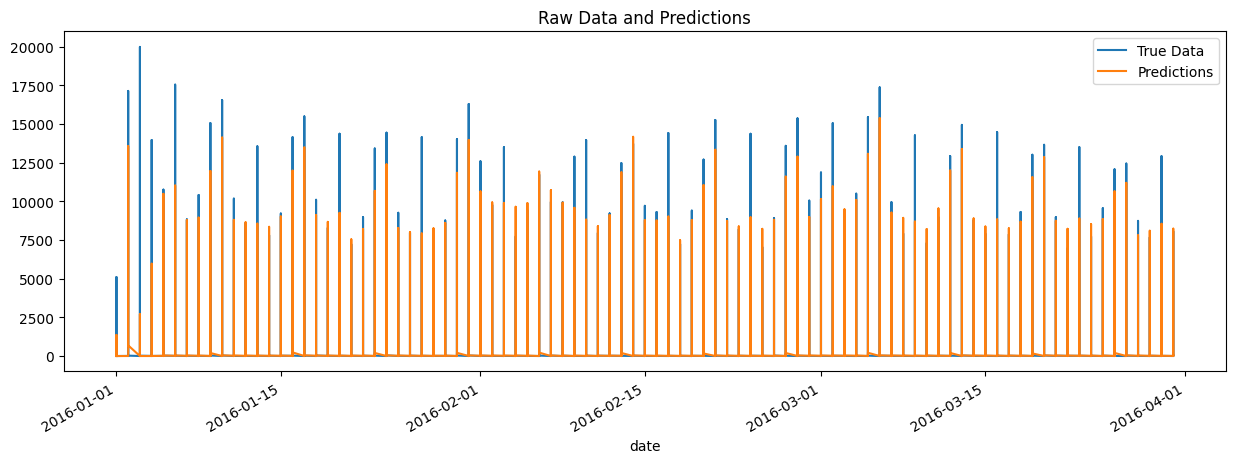

In [43]:
# Zoom in on a quarter
ax = test_set_final.loc[(test_set_final['date'] >= '2016-01-01') & (test_set_final['date'] < '2016-04-01')].plot(x='date', y='sales_actual', figsize=(15,5))
test_set_final.loc[(test_set_final['date'] >= '2016-01-01') & (test_set_final['date'] < '2016-04-01')].plot(ax=ax, x='date', y='sales_pred')
ax.set_title('Raw Data and Predictions')
plt.legend(['True Data', 'Predictions'])
plt.show()

## Observations

There were a small set of negative predictions we had to handle, but otherwise the predictions seem at least reasonable. Enough for a submission.

In [60]:
df_test = df_test0

In [61]:
# Create a model for submission.
df_test = join_all_to_df(df_test)
df_test = create_features(df_test)

# get dummies and drop id
df_test.drop('id', axis=1, inplace=True)

In [57]:
# I need to get more of the unique set of values than what is in the testing set evidently, so I'll get a subset of the original and combine them
# Everything joins on the the store number, so that's all I need really
df_train_subset = df_train0

df_train_subset = join_all_to_df(df_train_subset)
df_train_subset = create_features(df_train_subset)
df_train_subset.drop('id', axis=1, inplace=True)

In [64]:
df_train_subset.drop('sales', axis=1, inplace=True)

In [65]:
combined_df = pd.concat([df_train_subset, df_test])
df_test_combined = pd.get_dummies(combined_df)
df_test = df_test_combined[df_train_subset.shape[0]:]

df_test_preds = xgb_reg.predict(df_test)

In [66]:
df_test_preds = df_test_preds.clip(min=0)

In [67]:
df_submission = pd.DataFrame({'id': range(3000888, 3029400), 'sales' : df_test_preds})

In [69]:
df_submission.to_csv('submission_2.csv', index=False)